# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install resampy

In [ ]:
import os
import pandas as pd
import librosa
import shutil
import numpy as np
from scipy.io import wavfile as wav
from sklearn.decomposition import PCA
import random

def traverse_subfolders(subfolders):
    audio_files = []
    subfolder_names = []

    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        audio_files.extend(get_audio_files(subfolder))
        subfolder_names.extend([subfolder_name] * len(get_audio_files(subfolder)))

    return audio_files, subfolder_names

def get_audio_files(subfolder):
    audio_files = []

    for root, dirs, files in os.walk(subfolder):
        for file in files:
            if file.endswith(".ogg"):
                audio_files.append(os.path.join(root, file))

    return audio_files

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)#######
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

def process_audio_files(audio_files, subfolder_names, n_components):
    data = []

    for audio_file, subfolder_name in zip(audio_files, subfolder_names):
        compressed_data = features_extractor(audio_file)  # Extract MFCC features

        data.append([audio_file, compressed_data, subfolder_name])

    df = pd.DataFrame(data, columns=["File", "Compressed Data", "Subfolder Name"])
    return df


def compress_audio_pca(audio_data, n_components):
    # Reshape audio data to a 2D array
    audio_data_2d = audio_data.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=n_components)
    compressed_data_2d = pca.fit_transform(audio_data_2d)

    # Restore the compressed data to its original shape
    compressed_data = compressed_data_2d.reshape(-1)

    return compressed_data

# Delete existing directories if they exist
def delete_existing_dirs(origin_path):
    for folder in subfolders:
        path = os.path.join(origin_path, folder)
        shutil.rmtree(path, ignore_errors=True)


# Create new directories
def create_new_dirs(origin_path):
    for folder in subfolders:
        test_path = os.path.join(origin_path, folder)
        train_path = os.path.join(origin_path, folder)
        os.makedirs(test_path, exist_ok=True)
        os.makedirs(train_path, exist_ok=True)

def split_data(folder_path, train_path, test_path):
    temp = os.listdir(folder_path)
    training_samples = random.sample(temp, int(len(temp) * 0.75))
    test_samples = list(set(temp) - set(training_samples))

    # Copying to training directory
    for sample in training_samples:
        shutil.copy(os.path.join(folder_path, sample), train_path)

    # Copying to test directory
    for sample in test_samples:
        shutil.copy(os.path.join(folder_path, sample), test_path)


# Split to Train and Test

In [ ]:


# Path to the main directory containing subfolders
origin = '/content/drive/MyDrive/Dombyra dataset/Sounds/'

# List all subdirectories
subfolders = [f.name for f in os.scandir(origin) if f.is_dir()]

# Paths for Test and Train directories
origin_test = '/content/drive/MyDrive/Dombyra dataset/MFCC/Test/'
origin_train = '/content/drive/MyDrive/Dombyra dataset/MFCC/Train/'


delete_existing_dirs(origin_test)
delete_existing_dirs(origin_train)


create_new_dirs(origin_test)
create_new_dirs(origin_train)

In [ ]:
for folder in subfolders:
    folder_path = os.path.join(origin, folder)

    # Paths for Test and Train directories for the current subfolder
    train_path = os.path.join(origin_train, folder)
    test_path = os.path.join(origin_test, folder)


    # Split data
    split_data(folder_path, train_path, test_path)

# Feature Extraction

In [ ]:
# List all subdirectories in the Train directory
subfolders_training = [os.path.join(origin_train, folder) for folder in os.listdir(origin_train) if os.path.isdir(os.path.join(origin_train, folder))]

# List all subdirectories in the Test directory
subfolders_test = [os.path.join(origin_test, folder) for folder in os.listdir(origin_test) if os.path.isdir(os.path.join(origin_test, folder))]

n_components = 1

audio_files, subfolder_names = traverse_subfolders(subfolders_training)
df_training = process_audio_files(audio_files, subfolder_names, n_components)

audio_files_test, subfolder_names_test = traverse_subfolders(subfolders_test)
df_test = process_audio_files(audio_files_test, subfolder_names_test, n_components)

print(df_training)
print(df_test)

                                                  File  \
0    /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
1    /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
2    /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
3    /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
4    /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
..                                                 ...   
605  /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
606  /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
607  /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
608  /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   
609  /content/drive/MyDrive/Dombyra dataset/MFCC/Tr...   

                                       Compressed Data Subfolder Name  
0    [-449.8999, 91.63016, 35.684837, 19.209803, 3....            G-A  
1    [-462.66998, 87.41206, 30.147938, 12.793219, 1...            G-A  
2    [-472.44876, 85.442696, 34.91064, 18.176731, 6...            G-A  
3    [-476.4340

In [ ]:
df_training = df_training.drop("File",axis=1)
data = df_training.to_csv("Audio_data.csv")

df_test = df_test.drop("File",axis=1)
data_test = df_test.to_csv("Audio_data.csv")
df_training.rename(columns={"Subfolder Name":"class"},inplace=True)
df_test.rename(columns={"Subfolder Name":"class"},inplace=True)
df_training.head()

,Compressed Data,class
0,"[-449.8999, 91.63016, 35.684837, 19.209803, 3....",G-A
1,"[-462.66998, 87.41206, 30.147938, 12.793219, 1...",G-A
2,"[-472.44876, 85.442696, 34.91064, 18.176731, 6...",G-A
3,"[-476.43408, 89.24298, 34.144505, 18.548307, 4...",G-A
4,"[-491.9614, 96.45433, 34.849747, 14.37403, 3.7...",G-A


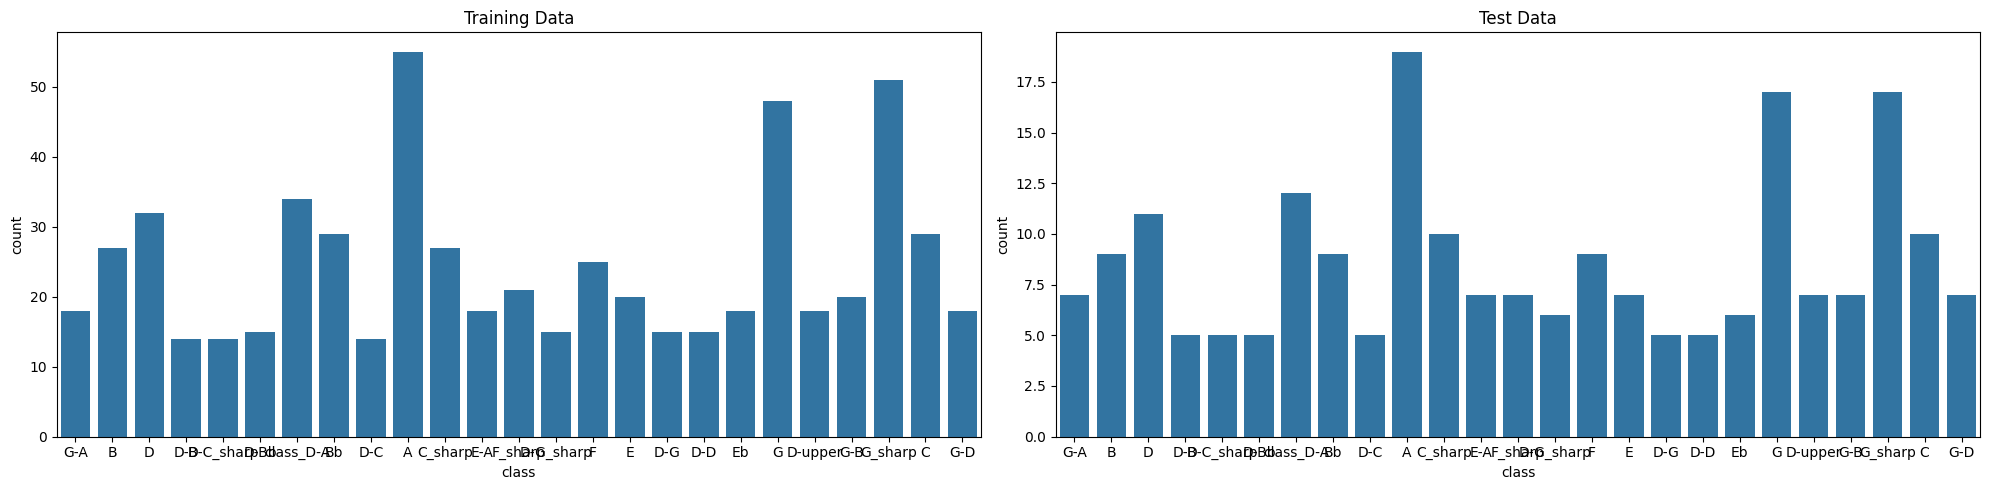

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение графика для df_training
plt.figure(figsize=(20, 5))  # Размер графика
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
sns.countplot(x="class", data=df_training)
plt.title('Training Data')  # Заголовок

# Построение графика для df_test
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
sns.countplot(x="class", data=df_test)
plt.title('Test Data')  # Заголовок

plt.tight_layout()  # Улучшает размещение графиков
plt.show()

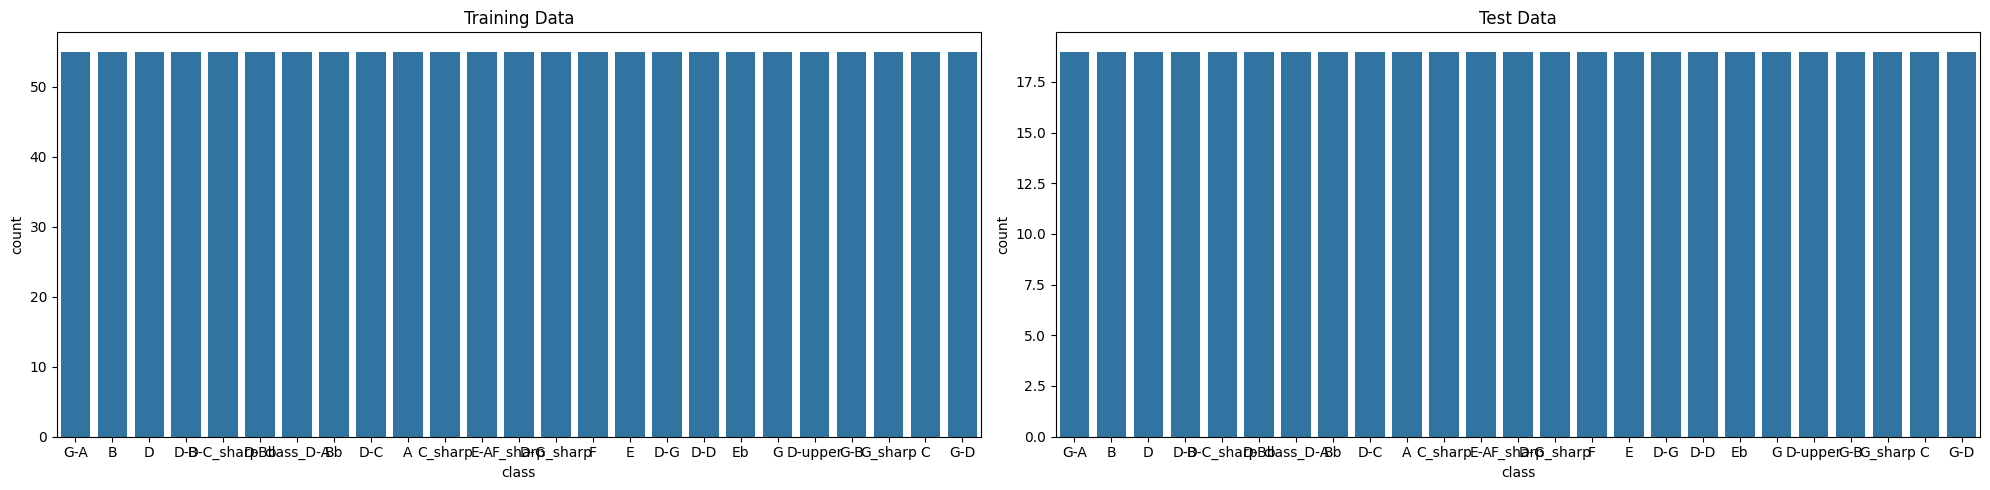

In [ ]:
x = df_training["Compressed Data"]
y = df_training["class"]

xt = df_test["Compressed Data"]
yt = df_test["class"]

from imblearn.over_sampling import RandomOverSampler
resamp = RandomOverSampler()
resamp2 = RandomOverSampler()
x = x.to_numpy()
x=x.reshape(-1,1)
x,y=resamp.fit_resample(x,y)

xt = xt.to_numpy()
xt=xt.reshape(-1,1)
xt,yt=resamp2.fit_resample(xt,yt)

# Построение графика для df_training
plt.figure(figsize=(20, 5))  # Размер графика
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
sns.countplot(x=y, data=df_training)
plt.title('Training Data')  # Заголовок

# Построение графика для df_test
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
sns.countplot(x=yt, data=df_test)
plt.title('Test Data')  # Заголовок

plt.tight_layout()  # Улучшает размещение графиков
plt.show()

In [ ]:
data = {'Data': x, 'class': y}
df_training = pd.DataFrame(x,columns=["Data"])
df_training["class"]=y

data_test = {'Data': xt, 'class': yt}
df_test = pd.DataFrame(xt,columns=["Data"])
df_test["class"]=yt


In [ ]:
df_new = df_training["Data"].apply(pd.Series)
df_result = pd.concat([df_training, df_new], axis=1)
df_result = df_result.drop('Data', axis=1)

df_new_test = df_test["Data"].apply(pd.Series)
df_result_test = pd.concat([df_test, df_new_test], axis=1)
df_result_test = df_result_test.drop('Data', axis=1)


df_result.head()


,class,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,G-A,-449.899902,91.630157,35.684837,19.209803,3.205993,4.526116,2.871189,4.314188,0.155215,...,-1.851930,-1.518849,-0.469225,2.420491,5.726394,6.651492,7.743355,6.306571,3.386258,1.835194
1,G-A,-462.669983,87.412064,30.147938,12.793219,1.922168,-1.052758,-4.403427,-1.970479,-1.392452,...,-0.489900,-0.615979,-1.869589,0.404636,6.417593,9.787192,7.172472,2.517194,1.277163,3.343221
2,G-A,-472.448761,85.442696,34.910641,18.176731,6.870178,5.505518,0.952081,-0.121440,-2.909013,...,-2.872298,-4.201944,-4.573147,-0.090287,7.557943,11.561993,8.890935,3.293761,0.505858,0.623845
3,G-A,-476.434082,89.242981,34.144505,18.548307,4.784379,4.263688,2.088786,1.982023,-1.031891,...,-1.843098,-1.698379,-3.031389,0.136062,6.792988,11.220901,8.856075,3.742579,1.092200,1.783016
4,G-A,-491.961395,96.454330,34.849747,14.374030,3.711926,2.708081,-1.290860,1.289086,-1.186041,...,-2.848622,-2.491889,-3.112988,-0.183682,7.791577,14.063624,11.223642,4.599464,1.233832,2.796073


In [ ]:
x = df_result.drop("class",axis=1)
y = df_result["class"]

xt = df_result_test.drop("class",axis=1)
yt = df_result_test["class"]

# Model Selection

In [ ]:
import sklearn
from sklearn.svm import SVC
max_acc = 0
svm_model = SVC(kernel = "rbf", C = 12)
svm_model = svm_model.fit(x, y)
y_pred = svm_model.predict(xt)
best_model = svm_model
print(sklearn.metrics.accuracy_score(yt,y_pred))
print(sklearn.metrics.classification_report(yt, y_pred))

if(max_acc<sklearn.metrics.accuracy_score(yt,y_pred)):
    max_acc = sklearn.metrics.accuracy_score(yt,y_pred)
    best_model = svm_model

0.8694736842105263
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        19
           B       1.00      1.00      1.00        19
          Bb       1.00      1.00      1.00        19
     C_sharp       1.00      0.89      0.94        19
           D       1.00      1.00      1.00        19
         D-B       0.68      1.00      0.81        19
        D-Bb       1.00      0.53      0.69        19
         D-C       0.79      1.00      0.88        19
   D-C_sharp       0.67      0.74      0.70        19
         D-D       1.00      0.79      0.88        19
         D-G       1.00      1.00      1.00        19
   D-G_sharp       1.00      1.00      1.00        19
     D-upper       1.00      0.42      0.59        19
           E       0.83      1.00      0.90        19
         E-A       0.79      1.00      0.88        19
          Eb       1.00      1.00      1.00        19
           F       1.00      1.00      1.00        19
     F_s

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5, metric = "minkowski" )
knn_model.fit(x, y)
pred = knn_model.predict(xt)
print(sklearn.metrics.accuracy_score(yt,pred))
print(sklearn.metrics.classification_report(yt, pred))

if(max_acc<sklearn.metrics.accuracy_score(yt,pred)):
    max_acc = sklearn.metrics.accuracy_score(yt,pred)
    best_model = knn_model

0.8842105263157894
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        19
           B       1.00      1.00      1.00        19
          Bb       1.00      1.00      1.00        19
     C_sharp       1.00      1.00      1.00        19
           D       1.00      1.00      1.00        19
         D-B       1.00      1.00      1.00        19
        D-Bb       1.00      1.00      1.00        19
         D-C       1.00      1.00      1.00        19
   D-C_sharp       0.73      1.00      0.84        19
         D-D       0.80      0.63      0.71        19
         D-G       1.00      1.00      1.00        19
   D-G_sharp       1.00      1.00      1.00        19
     D-upper       1.00      0.42      0.59        19
           E       1.00      1.00      1.00        19
         E-A       0.95      1.00      0.97        19
          Eb       0.83      1.00      0.90        19
           F       1.00      1.00      1.00        19
     F_s

In [ ]:
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression()
lg_model = lg_model.fit(x, y)
pred = lg_model.predict(xt)
print(sklearn.metrics.accuracy_score(yt,pred))
print(sklearn.metrics.classification_report(yt, pred))

if(max_acc<sklearn.metrics.accuracy_score(yt,pred)):
    max_acc = sklearn.metrics.accuracy_score(yt,pred)
    best_model = lg_model

0.9094736842105263
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        19
           B       1.00      0.79      0.88        19
          Bb       1.00      1.00      1.00        19
     C_sharp       1.00      1.00      1.00        19
           D       0.83      1.00      0.90        19
         D-B       1.00      1.00      1.00        19
        D-Bb       1.00      1.00      1.00        19
         D-C       1.00      1.00      1.00        19
   D-C_sharp       1.00      1.00      1.00        19
         D-D       1.00      1.00      1.00        19
         D-G       1.00      0.79      0.88        19
   D-G_sharp       1.00      1.00      1.00        19
     D-upper       1.00      0.79      0.88        19
           E       1.00      1.00      1.00        19
         E-A       0.95      1.00      0.97        19
          Eb       1.00      1.00      1.00        19
           F       1.00      1.00      1.00        19
     F_s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pickle
import joblib

clf_name = "ml.pkl"
joblib.dump(best_model,clf_name)

['ml.pkl']

In [ ]:
audio, sample_rate = librosa.load("/content/drive/MyDrive/Dombyra dataset/Sounds/A/1.ogg", res_type='kaiser_fast')
sample_rate

22050

In [ ]:
audio, sample_rate = librosa.load("/content/audio_with_noise_reduction.wav", res_type='kaiser_fast')
sample_rate

22050